In [63]:
def GetBatches(TrainingX, TrainingY):
    NumberBatches = 64

    #randomize order of the data set
    idx = torch.randperm(TrainingX.shape[0]) 
    print("IDX: ", idx)

    TrainingX = TrainingX[idx]
    TrainingY = TrainingY[idx]

    #split into batches
    newTrainingX = torch.split(TrainingX,int(len(TrainingX)/NumberBatches))
    newTrainingY = torch.split(TrainingY,int(len(TrainingY)/NumberBatches))

    return newTrainingX, newTrainingY

(20000, 1, 28, 28) float32
(20000,) int64
X torch.Size([20000, 1, 28, 28])
torch.Size([15000, 1, 28, 28])
(2000, 1, 28, 28) float32


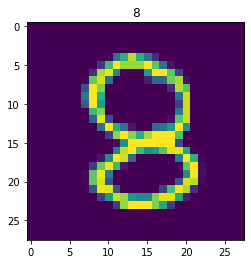

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from time import time

#https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

#FileNames
#inputFilename = 'prediction-challenge-01-data.npz'
inputFilename = 'sample_data/prediction-challenge-01-data.npz'
#outputFilename = 'prediction-challenge-01-data.npz'
outputFilename = 'prediction.npy'


with np.load(inputFilename) as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']



# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

X = torch.from_numpy(data_x)
Y = torch.from_numpy(data_y)
PredictMeX = torch.from_numpy(test_x)

print("X",X.shape)

#Build Testset from Trainingset
dataX = torch.split(X, [15000,5000])
dataY = torch.split(Y, [15000,5000])

TrainingX = dataX[0]
TestX = dataX[1]
TrainingY = dataY[0]
TestY = dataY[1]

#Alternatively, use all data for training:
#TrainingX = X
#TrainingY = Y

print(TrainingX.shape)
# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[0, 0])
plt.title(data_y[0])
plt.show()

#Build Model
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)
criterion = nn.NLLLoss()

In [65]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 100
     
for e in range(epochs):
    running_loss = 0
    
    losses = []

    BatchesX, BatchesY = GetBatches(TrainingX, TrainingY)
    
    for i in range(len(BatchesX)):
        #Flatten
        x = BatchesX[i]
        x = torch.flatten(x, start_dim = 1)
        y = BatchesY[i]
  
    
        # Training pass
        optimizer.zero_grad()

        output = model(x)
        loss = criterion(output, y)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss.item())

    print("Epoch {} - Training loss: {}".format(e, running_loss/len(BatchesX[0])))
    
    #print('weights 1',torch.nonzero(model[0].weight.grad ))


print("\nTraining Time (in minutes) =",(time()-time0)/60) 


IDX:  tensor([12984, 13673,  2077,  ...,  9351,  7736, 12019])
Epoch 0 - Training loss: 0.8946635379241064
IDX:  tensor([2245, 1529, 1341,  ..., 6669, 5398, 1304])
Epoch 1 - Training loss: 0.2556478749228339
IDX:  tensor([ 9239,  9806,  9779,  ...,  8837, 11021,  4271])
Epoch 2 - Training loss: 0.1329947209511048
IDX:  tensor([10623,  2185,  1192,  ...,  7842, 12499, 11019])
Epoch 3 - Training loss: 0.0901601818891672
IDX:  tensor([ 5120,  8954,  3484,  ..., 10500,   344,   338])
Epoch 4 - Training loss: 0.07359974818606661
IDX:  tensor([ 7157,  4586,  2453,  ..., 14364,  9230, 13943])
Epoch 5 - Training loss: 0.07295325357053015
IDX:  tensor([ 3065, 13363, 13876,  ..., 12788, 10902,   569])
Epoch 6 - Training loss: 0.061219577160146504
IDX:  tensor([  525, 12562,  9050,  ...,  4003, 13305,  2305])
Epoch 7 - Training loss: 0.06027685010280365
IDX:  tensor([13074,   272,  2109,  ..., 13114,  1419, 12886])
Epoch 8 - Training loss: 0.05813948138274698
IDX:  tensor([4233, 6445, 8270,  ...,

Number Of Images Tested = 5000
Correct predictions = 4701

Model Accuracy = 0.9402
Wrong predicted labels: 


<BarContainer object of 10 artists>

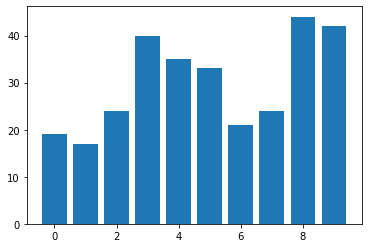

In [66]:
# Test Model
correct_count, all_count = 0, 0

wrong_predictions = []

for i in range(TestX.shape[0]):
    image = torch.flatten(TestX[i], start_dim = 1)

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(image)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = TestY[i]
    if true_label == pred_label:
        correct_count += 1
    else:
      wrong_predictions.append(pred_label)
    all_count += 1

print("Number Of Images Tested =", all_count)
print("Correct predictions =", correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

values, counts = np.unique(wrong_predictions, return_counts=True)
print("Wrong predicted labels: ")
plt.bar(values, counts)

In [67]:
#Visualize test data and prediction
modelprediction = []
for x in PredictMeX:
    #x = torch.from_numpy(x)
    image = torch.flatten(x, start_dim = 1)

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(image)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    modelprediction.append(pred_label)
    
    #plt.imshow(x.reshape(28,28))
    #plt.title(pred_label)
    #plt.show()

In [68]:
import numpy as np

prediction = np.asarray(modelprediction)# THAT'S YOUR JOB

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save(outputFilename, prediction)

Predictions:  2000


<BarContainer object of 10 artists>

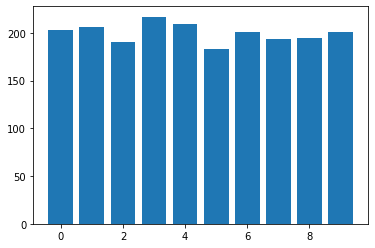

In [69]:
#import pandas as pd

#df = pd.DataFrame(data=prediction)

print("Predictions: ", prediction.size)

values, counts = np.unique(prediction, return_counts=True)
#df = pd.DataFrame(data=counts, columns=values)

plt.bar(values, counts)